# 라이브러리 불러오기

In [6]:
!pip install koreanize_matplotlib -q
!pip install statsmodels -q
!pip install konlpy -q
!pip install mecab-python3 -q


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import numpy as np
import koreanize_matplotlib
import warnings
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from konlpy.tag import Okt
import MeCab
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from collections import Counter

warnings.simplefilter(action='ignore')

%config InlineBackend.figure_format = 'retina'

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [3]:
# application = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\Application.csv', index_col=0)
# company = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\Company.csv', index_col=0)
# company_address = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\CompanyAddress.csv', index_col=0)
# company_fund = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\CompanyFund.csv', index_col=0)
# job = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\Job.csv', index_col=0)
# job_address = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\JobAddress.csv', index_col=0)
# job_bookmark = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\JobBookmark.csv', index_col=0)
# log2022 = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\log_2022.csv', index_col=0)
# log2023 = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\log_2023.csv', index_col=0)

In [4]:
# 필요한 데이터만 추출
log2022 = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\log_2022.csv', index_col=0)
log2023 = pd.read_csv(r'C:\Users\hbyr0\Desktop\가이드액션_기능개선_프로젝트\사이드프로젝트\input\log_2023.csv', index_col=0)

In [5]:
log2022['timestamp'].describe

<bound method NDFrame.describe of 0           2022-06-22 16:42:48.247454 UTC
1           2022-06-22 16:19:07.770741 UTC
2           2022-06-22 16:41:54.449837 UTC
3           2022-06-23 02:53:47.040932 UTC
4           2022-06-22 16:21:58.154299 UTC
                         ...              
10054119    2022-07-28 00:34:34.781394 UTC
10054120     2022-04-06 03:28:19.99548 UTC
10054121    2022-11-14 12:11:53.841597 UTC
10054122    2022-02-10 05:58:29.778388 UTC
10054123    2022-02-03 02:54:20.404898 UTC
Name: timestamp, Length: 10054124, dtype: object>

In [4]:
# 두 로그 합하기
log = pd.concat([log2022, log2023])

```
노동시장
2021년 1월 약 100만개의 일자리 감소,
2021년 3월부터 고용이 빠르게 회복되어 2022년 9월 코로나 이전 상태로 회복됨

그러므로 2022년 10월 이후 건으로 살펴 보겠음
```

In [5]:
# 2022년 10월 이후 로그
log = log[log['timestamp'] >= '2022-10']

# 유저별, 기간별 정렬
log.sort_values(['user_uuid', 'timestamp'], inplace=True)

In [6]:
# 날짜 데이터 형태 변환
log['date'] = pd.to_datetime(log['date'])

# 전처리

### sort_log 데이터 전처리

#### sort_log / NULL 처리

In [7]:
# log 개수, NULL값 확인,  NULL값 비율 확인
print(f"전체 log 수 : {len(log['URL'])}")
print(f"-" * 50)
print(f"NULL 수 : {log.isnull().sum()}")
print(f"-" * 50)
print(f"NULL 비율 {log.isnull().sum() / len(log['URL']) * 100} %")

# NULL제거
sort_log = log.dropna()
print(f"NULL 제거 후 log 수 : {len(sort_log)}")

전체 log 수 : 9168775
--------------------------------------------------
NULL 수 : user_uuid             0
URL              347658
timestamp             0
date                  0
response_code         0
method                0
dtype: int64
--------------------------------------------------
NULL 비율 user_uuid        0.000000
URL              3.791761
timestamp        0.000000
date             0.000000
response_code    0.000000
method           0.000000
dtype: float64 %
NULL 제거 후 log 수 : 8821117


#### sort_log / response 처리

In [8]:
sort_log = sort_log[sort_log['response_code'].isin([200, 301, 302])]
print(f"비정상적으로 서버요청 된 url 수 : {8821117 - len(sort_log)}")
print(f"비정상적으로 서버요청 된 url 비율 : {((8821117 - len(sort_log)) / 8821117) * 100} %")

print(f"제거 후 log 수 : {len(sort_log)}")

비정상적으로 서버요청 된 url 수 : 68028
비정상적으로 서버요청 된 url 비율 : 0.7711948498132379 %
제거 후 log 수 : 8753089


#### sort_log / UTC → 한국시간대 로 변경

In [9]:
sort_log['timestamp'] = sort_log['timestamp'].str.replace(' UTC', '',regex=False)
sort_log['timestamp'] = pd.to_datetime(sort_log['timestamp'], utc=True, format='mixed')
sort_log['timestamp'] = sort_log['timestamp'].dt.tz_convert('Asia/Seoul')

#### sort_log / 세션 추가

In [10]:
sort_log['prev_time'] = sort_log.groupby('user_uuid')['timestamp'].shift(1)  # 전 행
sort_log['time_diff'] = (sort_log['timestamp'] - sort_log['prev_time']).dt.total_seconds()  # 초단위

# 구글 애널리스틱 표준 세션 시간 30분(1800초)
# 30분(1800초) 이상 or 시간차가 없으면(유저 구분) 새로운 세션
sort_log['new_session'] = (sort_log['time_diff'] > 1800) | (sort_log['time_diff'].isna()) 

sort_log['session_id'] = sort_log.groupby('user_uuid')['new_session'].cumsum()

In [11]:
print(f" 세션 공백 시간 기술통계 : {round(sort_log['time_diff'].describe(), 2)}")
print('-' * 50)
print(f" 세션 id 기술적 통계 : {round(sort_log['session_id'].describe(), 2)}")

 세션 공백 시간 기술통계 : count     8736214.00
mean        29239.71
std        453361.50
min             0.00
25%             0.60
50%             2.48
75%            13.82
max      38369891.27
Name: time_diff, dtype: float64
--------------------------------------------------
 세션 id 기술적 통계 : count    8753089.00
mean          52.49
std           95.52
min            1.00
25%            6.00
50%           20.00
75%           57.00
max         1699.00
Name: session_id, dtype: float64


```
구글애널리스틱 표준 세션 시간 기준(30분)
→ 30분 이상 아무 행동 없으면, 세션이 끝난 것으로 간주
```

In [12]:
round(sort_log['session_id'].describe())

count    8753089.0
mean          52.0
std           96.0
min            1.0
25%            6.0
50%           20.0
75%           57.0
max         1699.0
Name: session_id, dtype: float64

#### sort_log 이상치 제거

```
1. URL 수가 과도하게 많은 유저 확인
```

In [28]:
sort_log_URL_count = sort_log.groupby('user_uuid')['URL'].count().reset_index()

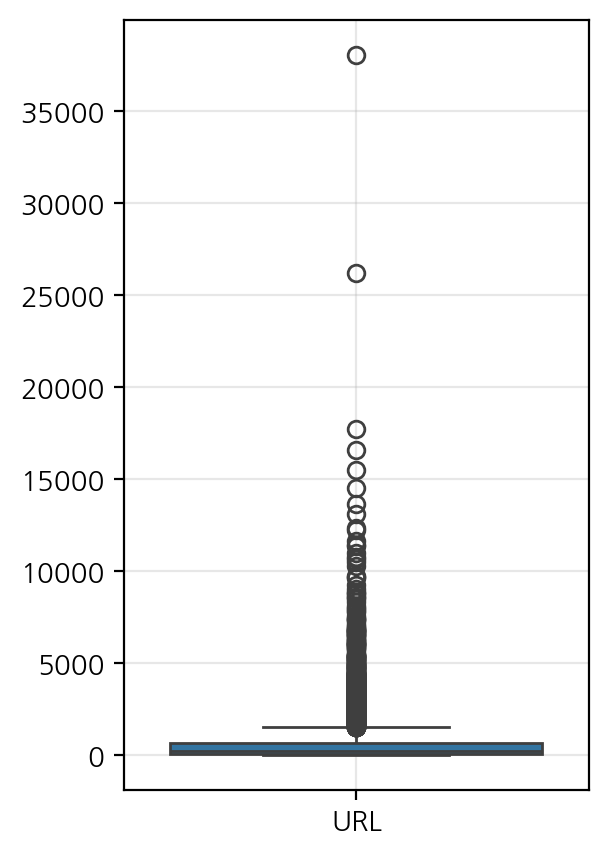

In [29]:
plt.figure(figsize=(3,5))
sns.boxplot(data= sort_log_URL_count)
plt.grid(alpha=0.3)
plt.xticks()
plt.show()

```
zscore을 통해 URL이 과도하게 많은 유저 272명 제거
```

In [31]:
# zscore 사용
from scipy.stats import zscore

zs = np.abs(zscore(sort_log_URL_count['URL']))
fiter_mask = zs < 3
zscore_clean = sort_log_URL_count[fiter_mask]

In [32]:
print(f" 제거 전 유저 수 : {sort_log_URL_count['user_uuid'].nunique()}")
print(f" 제거 후 유저 수 : {zscore_clean['user_uuid'].nunique()}")
print(f" 제거 된 유저수 : {sort_log_URL_count['user_uuid'].nunique() - zscore_clean['user_uuid'].nunique()}")

 제거 전 유저 수 : 16875
 제거 후 유저 수 : 16603
 제거 된 유저수 : 272


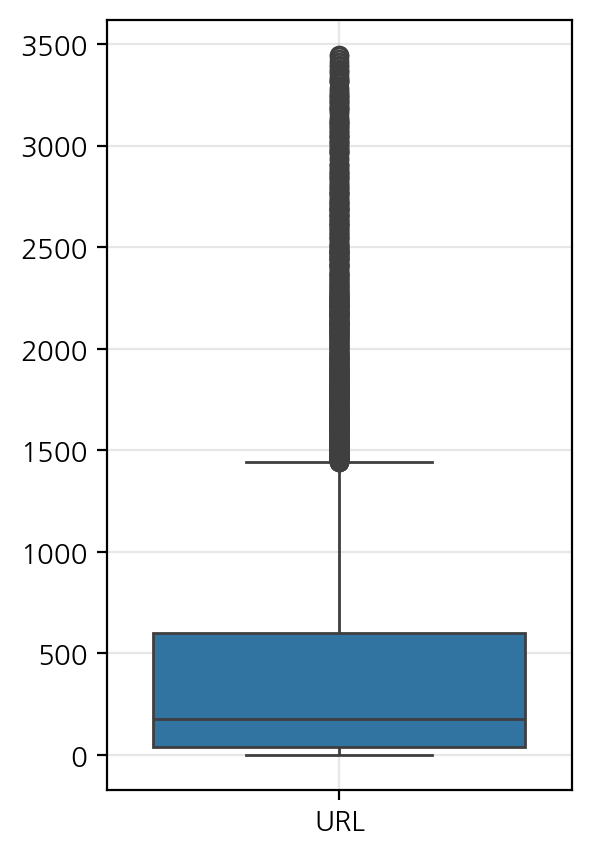

In [20]:
plt.figure(figsize=(3,5))
sns.boxplot(data= zscore_clean)
plt.grid(alpha=0.3)
plt.xticks()
plt.show()

In [48]:
# zscore 기준 적합 유저
zscore_user_uuid = zscore_clean['user_uuid'].unique()

# zscore 미충족 유저 제거
sort_log = sort_log[sort_log['user_uuid'].isin(zscore_user_uuid)]

```
퍼널 :
    탐색 > 가이드 액션 > 지원서 작성 > 지원 작성 완료
    가이드 액션 > 탐색 > 지원서 작성 > 지원 작성 완료
    

    ** 가이드액션(기능 사용 여부) > 지원 작성 완료 DecisionTree
    ** 가이드액션(기능 사용 횟수가 많아질 수록) > 지원 작성 완료 Regresion
 
    
    가이드액션 머무르는 시간 (가이드액션 기능 중 가장 오래 머무른다 > 기능이 불편할 것이다 > 개선)
    가이드 기능 사용 횟수
```

### ACTION_TYPE 정의

In [24]:
def classify_action(cleaned_URL, method=None):

    # 1. 결측값 및 문자열 정제
    if pd.isna(cleaned_URL):
        return 'etc'

    cleaned_URL = str(cleaned_URL).lower().strip()
    if cleaned_URL == '':
        return 'etc'

    # 2. method 정제 (대소문자, 공백 포함 가능성 대응)
    if method:
        method = str(method).strip().lower()

    # 3. 회원가입 관련
    if 'signup' in cleaned_URL and 'done' in cleaned_URL:
        return 'signup-done'
    elif 'signup' in cleaned_URL:
        return 'signup-click'

    # 4. 지원 흐름 상세 구분
    if 'apply_progress' in cleaned_URL:
        return 'apply-progress'
    elif 'application' in cleaned_URL or 'resume' in cleaned_URL:
        return 'apply-update'
    elif 'apply' in cleaned_URL and 'step4' in cleaned_URL:
        if method == 'post':
            return 'applydone'
        else:
            return 'apply-step4'
    elif 'apply' in cleaned_URL and 'step3' in cleaned_URL:
        return 'apply-step3'
    elif 'apply' in cleaned_URL and 'step2' in cleaned_URL:
        return 'apply-step2'
    elif 'apply' in cleaned_URL and 'step1' in cleaned_URL:
        return 'apply-step1'
    elif 'apply' in cleaned_URL:
        return 'apply-click'
    
    # 5. 채용 관련
    if 'job' in cleaned_URL and 'bookmark' in cleaned_URL:
        return 'job-bookmark'
    elif 'job' in cleaned_URL or 'recruit' in cleaned_URL:
        return 'job-recruit'
    elif ('companies' in cleaned_URL or 'company'in cleaned_URL) and 'member' in cleaned_URL:
        return 'companies-member'
    elif (('companies' in cleaned_URL or 'company' in cleaned_URL) and 'view' in cleaned_URL) or 'companies/company_id' in cleaned_URL:
        return 'companies-view'
    elif ('companies' in cleaned_URL or 'companies' in cleaned_URL) and 'bookmark' in cleaned_URL:
        return 'companies-bookmark'

    # 6. 추천 및 가이드
    if 'recommend' in cleaned_URL:
        return ''
    elif 'current_guided_action' in cleaned_URL:
        return 'guideclick'
    elif 'guided_action/add_sns_card' in cleaned_URL:
        return 'guide-snscard'
    elif 'guided_action/add_specialty_card' in cleaned_URL:
        return 'guide-specialty'
    elif 'guided_action/add_language_card' in cleaned_URL:
        return 'guide-language'
    elif 'guided_action/add_career_card' in cleaned_URL:
        return 'guide-career'
    elif 'guided_action/add_news_card' in cleaned_URL:
        return 'guide-newscard'
    elif 'guided_action/add_overview_card' in cleaned_URL:
        return 'guide-overview'
    elif 'guided_action/add_funding_card' in cleaned_URL:
        return 'guide-funding'
    
    # 7. 프로필 관련
    if any(x in cleaned_URL for x in ['profile', 'template', 'experience', 'education',
                              'career', 'project', 'overview', 'image',
                              'specialty', 'sns', 'certification', 'language', 'residence']):
        return 'profile'

    # 8. 일반 기능
    if 'search' in cleaned_URL:
        return 'search'
    elif 'setting' in cleaned_URL:
        return 'profile-setting'
    elif 'verify' in cleaned_URL:
        return 'profile-verify'
    elif 'notifications' in cleaned_URL:
        return 'profile-notify'

    # 9. 소셜 기능
    if 'follower' in cleaned_URL or 'following' in cleaned_URL or 'bookmark' in cleaned_URL:
        return 'social'

    # 10. 기타
    return 'etc'

In [49]:
# 'apply'가 포함된 URL 중에서 '?' 뒤에 'apply'가 포함된 경우 필터링
def apply_after_question_mark(url):
    if pd.isna(url):
        return False
    parts = url.split('?', 1)
    # '?' 뒤 부분이 있고, 그 부분에 'apply' 포함 여부 검사
    return len(parts) == 2 and 'apply' in parts[1]

#필터링
filtered_df = sort_log[sort_log['URL'].apply(apply_after_question_mark)]

#개수 출력
print(len(filtered_df))

#URL에서 쿼리 파라미터 제거 및 정리
sort_log[['cleaned_URL', 'query_params']] = sort_log['URL'].str.split('?', expand=True)

#명사 추출 함수
def extract_nouns(url):
    okt = Okt()
    # URL에서 '/'를 기준으로 분리하고, 각 부분에서 명사 추출
    nouns = []
    for part in url.split('/'):
        nouns.extend(okt.nouns(part))
    return ' '.join(nouns)

169830


In [50]:
# 액션타입 컬럼 추가
sort_log['action_type'] = sort_log.apply(
    lambda row: classify_action(row['cleaned_URL'], row['method']),
    axis=1
)

In [51]:
sort_log = sort_log[sort_log['action_type'] != '']

In [52]:
# 저장
sort_log.to_csv('cleaned_log.csv', encoding='utf-8')